# Setup & Install


In [1]:

import sys, subprocess, importlib, warnings, os, math, random
warnings.filterwarnings("ignore")

def ensure(pkg, import_name=None, extras=None):
    """Install `pkg` if missing, then import and return module."""
    name = import_name or pkg
    try:
        return importlib.import_module(name)
    except ImportError:
        to_install = pkg if not extras else f"{pkg}[{extras}]"
        print(f"[INFO] Installing {to_install} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", to_install])
        return importlib.import_module(name)

np = ensure("numpy")
pd = ensure("pandas")
plt = ensure("matplotlib.pyplot", import_name="matplotlib.pyplot")
skmetrics = ensure("sklearn.metrics", import_name="sklearn.metrics")
MinMaxScaler = ensure("sklearn.preprocessing", import_name="sklearn.preprocessing").MinMaxScaler
train_test_split = ensure("sklearn.model_selection", import_name="sklearn.model_selection").train_test_split
yfinance = ensure("yfinance")
pmdarima = ensure("pmdarima")
auto_arima = pmdarima.arima.auto_arima

# TensorFlow (CPU) for LSTM
try:
    tf = importlib.import_module("tensorflow")
except ImportError:
    print("[INFO] Installing tensorflow (CPU) ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"])
    tf = importlib.import_module("tensorflow")
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)



# PART 1) Download Data


In [3]:
import datetime as dt
END = dt.date.today()
START = dt.date(2015, 1, 1)

print("[INFO] Downloading AAPL data from Yahoo Finance ...")
df = yfinance.download("AAPL", start=str(START), end=str(END), progress=False)
if df is None or df.empty:
    raise RuntimeError("Failed to download AAPL data from Yahoo. Check your internet connection.")

# Use Adjusted Close for modeling
df = df[['Close','Volume']].copy()
#df.rename(columns={'Adj Close':'AdjClose'}, inplace=True)
df.dropna(inplace=True)

# Convert to business day frequency and forward fill
df = df.asfreq('B')
#df['AdjClose'] = df['AdjClose'].ffill()
df['Close'] = df['Close'].ffill()
df['Volume'] = df['Volume'].ffill()


[INFO] Downloading AAPL data from Yahoo Finance ...


# PART 2) Feature Engineering (for SARIMAX)

In [5]:

# Create some simple exogenous features (no lookahead leakage)
df['Return1'] = df['Close'].pct_change()
df['RollMean5'] = df['Close'].rolling(5).mean()
df['RollStd5']  = df['Close'].rolling(5).std()

# Replace initial NaNs safely using modern pandas methods
for c in ['Return1','RollMean5','RollStd5']:
    df[c] = df[c].bfill()


In [6]:
df.head()

Price,Close,Volume,Return1,RollMean5,RollStd5
Ticker,AAPL,AAPL,,,
Date,,,,,
2015-01-02,24.261044,212818400.0,-0.028172,24.031592,0.527647
2015-01-05,23.577572,257142000.0,-0.028172,24.031592,0.527647
2015-01-06,23.579788,263188400.0,0.000094,24.031592,0.527647
2015-01-07,23.910433,160423600.0,0.014022,24.031592,0.527647
2015-01-08,24.829124,237458000.0,0.038422,24.031592,0.527647


# PART 3) Train/Test Split


In [8]:

# Last ~120 business days as test (about ~6 months)
TEST_SIZE = 120
if len(df) <= TEST_SIZE + 200:
    TEST_SIZE = max(30, len(df)//5)  # fallback

target = df['Close'].copy()
exog = df[['Return1','RollMean5','RollStd5']].copy()

y_train, y_test = target.iloc[:-TEST_SIZE], target.iloc[-TEST_SIZE:]
X_train, X_test = exog.iloc[:-TEST_SIZE], exog.iloc[-TEST_SIZE:]

print(f"[INFO] Train length: {len(y_train)}, Test length: {len(y_test)}")



[INFO] Train length: 2666, Test length: 120


# PART 4) Metrics Helpers

In [9]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def evaluate(y_true, y_pred, name):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mp   = mape(y_true, y_pred)
    return {"model": name, "RMSE": rmse, "MAE": mae, "MAPE%": mp}

results = []
predictions_df = pd.DataFrame(index=y_test.index)
predictions_df['Actual'] = y_test



# PART 5) ARIMA (auto)

In [10]:

print("[INFO] Fitting ARIMA (auto_arima, non-seasonal) ...")
try:
    arima_model = auto_arima(
        y=y_train, 
        seasonal=False, 
        stepwise=True, 
        error_action='ignore', 
        suppress_warnings=True, 
        trace=False,
        max_p=5, max_q=5  # Limit search space for stability
    )
    arima_forecast = arima_model.predict(n_periods=len(y_test))
    predictions_df['ARIMA'] = arima_forecast
    results.append(evaluate(y_test, arima_forecast, "ARIMA"))
    print("[INFO] ARIMA model fitted successfully")
except Exception as e:
    print(f"[WARNING] ARIMA failed: {e}")
    predictions_df['ARIMA'] = np.nan



[INFO] Fitting ARIMA (auto_arima, non-seasonal) ...
[INFO] ARIMA model fitted successfully


# PART 6) SARIMA
 * (auto, weekly seasonality m=5)


In [11]:

print("[INFO] Fitting SARIMA (auto_arima, seasonal m=5) ...")
try:
    sarima_model = auto_arima(
        y=y_train,
        seasonal=True, m=5,           # 5 business-day weekly seasonality
        stepwise=True,
        error_action='ignore',
        suppress_warnings=True,
        trace=False,
        max_p=3, max_q=3, max_P=2, max_Q=2  # Limit search space
    )
    sarima_forecast = sarima_model.predict(n_periods=len(y_test))
    predictions_df['SARIMA'] = sarima_forecast
    results.append(evaluate(y_test, sarima_forecast, "SARIMA"))
    print("[INFO] SARIMA model fitted successfully")
except Exception as e:
    print(f"[WARNING] SARIMA failed: {e}")
    predictions_df['SARIMA'] = np.nan


[INFO] Fitting SARIMA (auto_arima, seasonal m=5) ...
[INFO] SARIMA model fitted successfully


# PART 7) SARIMAX 
* (auto with exogenous features)


In [12]:
print("[INFO] Fitting SARIMAX (auto_arima with exog, seasonal m=5) ...")
try:
    sarimax_model = auto_arima(
        y=y_train,
        X=X_train,
        seasonal=True, m=5,
        stepwise=True,
        error_action='ignore',
        suppress_warnings=True,
        trace=False,
        max_p=3, max_q=3, max_P=2, max_Q=2
    )
    sarimax_forecast = sarimax_model.predict(n_periods=len(y_test), X=X_test)
    predictions_df['SARIMAX'] = sarimax_forecast
    results.append(evaluate(y_test, sarimax_forecast, "SARIMAX"))
    print("[INFO] SARIMAX model fitted successfully")
except Exception as e:
    print(f"[WARNING] SARIMAX failed: {e}")
    predictions_df['SARIMAX'] = np.nan



[INFO] Fitting SARIMAX (auto_arima with exog, seasonal m=5) ...
[INFO] SARIMAX model fitted successfully


# PART 8) LSTM 

In [13]:

print("[INFO] Training LSTM ...")
try:
    # Scale target for LSTM
    scaler = MinMaxScaler()
    scaled_all = scaler.fit_transform(target.values.reshape(-1,1)).astype(np.float32)
    scaled_train = scaled_all[:-TEST_SIZE]
    
    # Ensure we have enough data for the window
    WINDOW = min(60, len(scaled_train) // 4)  # Adaptive window size
    scaled_test = scaled_all[-(TEST_SIZE + WINDOW):]  # include history for windowing
    
    def create_sequences(arr, window):
        Xs, ys = [], []
        for i in range(window, len(arr)):
            Xs.append(arr[i-window:i, 0])
            ys.append(arr[i, 0])
        return np.array(Xs), np.array(ys)

    X_train_seq, y_train_seq = create_sequences(scaled_train, WINDOW)
    X_test_seq,  y_test_seq  = create_sequences(scaled_test, WINDOW)
    
    if len(X_train_seq) == 0 or len(X_test_seq) == 0:
        raise ValueError("Insufficient data for LSTM windowing")

    # Reshape for LSTM: (samples, timesteps, features)
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
    X_test_seq  = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

    # Build a simple but solid LSTM model
    model = keras.Sequential([
        layers.Input(shape=(WINDOW, 1)),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.1),
        layers.LSTM(32),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.15,
        epochs=80,
        batch_size=32,
        callbacks=[early],
        verbose=0
    )

    # Predict & invert scale
    lstm_pred_scaled = model.predict(X_test_seq, verbose=0).reshape(-1,1)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled).ravel()

    # Align LSTM predictions with test set
    # Take the last len(y_test) predictions to align with test period
    predictions_df['LSTM'] = lstm_pred[-len(y_test):]
    results.append(evaluate(y_test, predictions_df['LSTM'], "LSTM"))
    print("[INFO] LSTM model trained successfully")

except Exception as e:
    print(f"[WARNING] LSTM failed: {e}")
    predictions_df['LSTM'] = np.nan



[INFO] Training LSTM ...
[INFO] LSTM model trained successfully


# PART 9) Results & Plots


=== Test Metrics (lower is better) ===
            RMSE      MAE   MAPE%
model                            
SARIMAX   4.9944   3.3436  6.4430
LSTM      5.2008   3.2007  6.7071
ARIMA    17.0114  14.8226  7.7441
SARIMA   20.3195  17.5953  9.1818


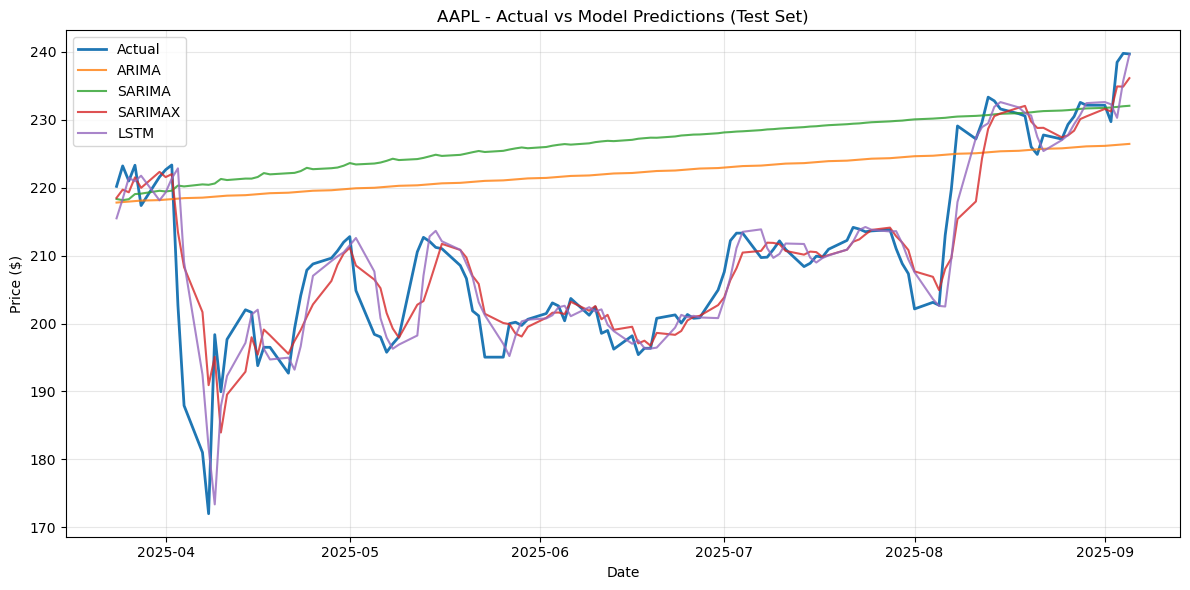

In [14]:

if results:
    metrics_df = pd.DataFrame(results).set_index('model').sort_values('RMSE')
    print("\n=== Test Metrics (lower is better) ===")
    print(metrics_df.round(4))
else:
    print("\n[WARNING] No models were successfully fitted!")
    metrics_df = pd.DataFrame()

# Plot Actual vs Predictions
plt.figure(figsize=(12,6))
plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual', linewidth=2)

# Plot only successful model predictions
model_cols = ['ARIMA', 'SARIMA', 'SARIMAX', 'LSTM']
for col in model_cols:
    if col in predictions_df.columns and not predictions_df[col].isna().all():
        plt.plot(predictions_df.index, predictions_df[col], label=col, alpha=0.8)

plt.title("AAPL - Actual vs Model Predictions (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# PART 10) Save Outputs


In [20]:

out_dir = "model_outputs"
os.makedirs(out_dir, exist_ok=True)
pred_path = os.path.join(out_dir, "aapl_predictions.csv")
metrics_path = os.path.join(out_dir, "aapl_metrics.csv")

predictions_df.to_csv(pred_path)
if not metrics_df.empty:
    metrics_df.to_csv(metrics_path)

print(f"\n[INFO] Saved predictions to: {pred_path}")
if not metrics_df.empty:
    print(f"[INFO] Saved metrics to:     {metrics_path}")



[INFO] Saved predictions to: model_outputs\aapl_predictions.csv
[INFO] Saved metrics to:     model_outputs\aapl_metrics.csv


# PART 11 Forecasts

## PART 11) Next-day Forecasts

In [16]:
print("\n=== Next Business Day Forecasts (point) ===")
last_exog = exog.iloc[[-1]]

try:
    if 'arima_model' in locals():
        arima_next = float(arima_model.predict(n_periods=1)[0])
        print(f"ARIMA  next: ${arima_next:.2f}")
except Exception as e:
    print(f"ARIMA  next: Failed ({e})")

try:
    if 'sarima_model' in locals():
        sarima_next = float(sarima_model.predict(n_periods=1)[0])
        print(f"SARIMA next: ${sarima_next:.2f}")
except Exception as e:
    print(f"SARIMA next: Failed ({e})")

try:
    if 'sarimax_model' in locals():
        sarimax_next = float(sarimax_model.predict(n_periods=1, X=last_exog)[0])
        print(f"SARIMAX next: ${sarimax_next:.2f}")
except Exception as e:
    print(f"SARIMAX next: Failed ({e})")

try:
    if 'model' in locals() and 'scaler' in locals():
        # LSTM next-day: take last WINDOW points, predict one step ahead
        last_window = scaled_all[-WINDOW:].reshape(1, WINDOW, 1)
        lstm_next_scaled = model.predict(last_window, verbose=0).ravel()[0]
        lstm_next = float(scaler.inverse_transform([[lstm_next_scaled]])[0,0])
        print(f"LSTM   next: ${lstm_next:.2f}")
except Exception as e:
    print(f"LSTM   next: Failed ({e})")

print("\n[INFO] Script completed successfully!")


=== Next Business Day Forecasts (point) ===
ARIMA  next: $217.81
SARIMA next: $218.34
SARIMAX next: $238.26
LSTM   next: $240.44

[INFO] Script completed successfully!


## PART 11)  Next Week Forecasts


=== Next Week (5 Business Days) Forecasts ===
ARIMA  week-end: $218.10
SARIMA week-end: $219.13
SARIMAX week-end: $236.04
LSTM   week-end: $240.54


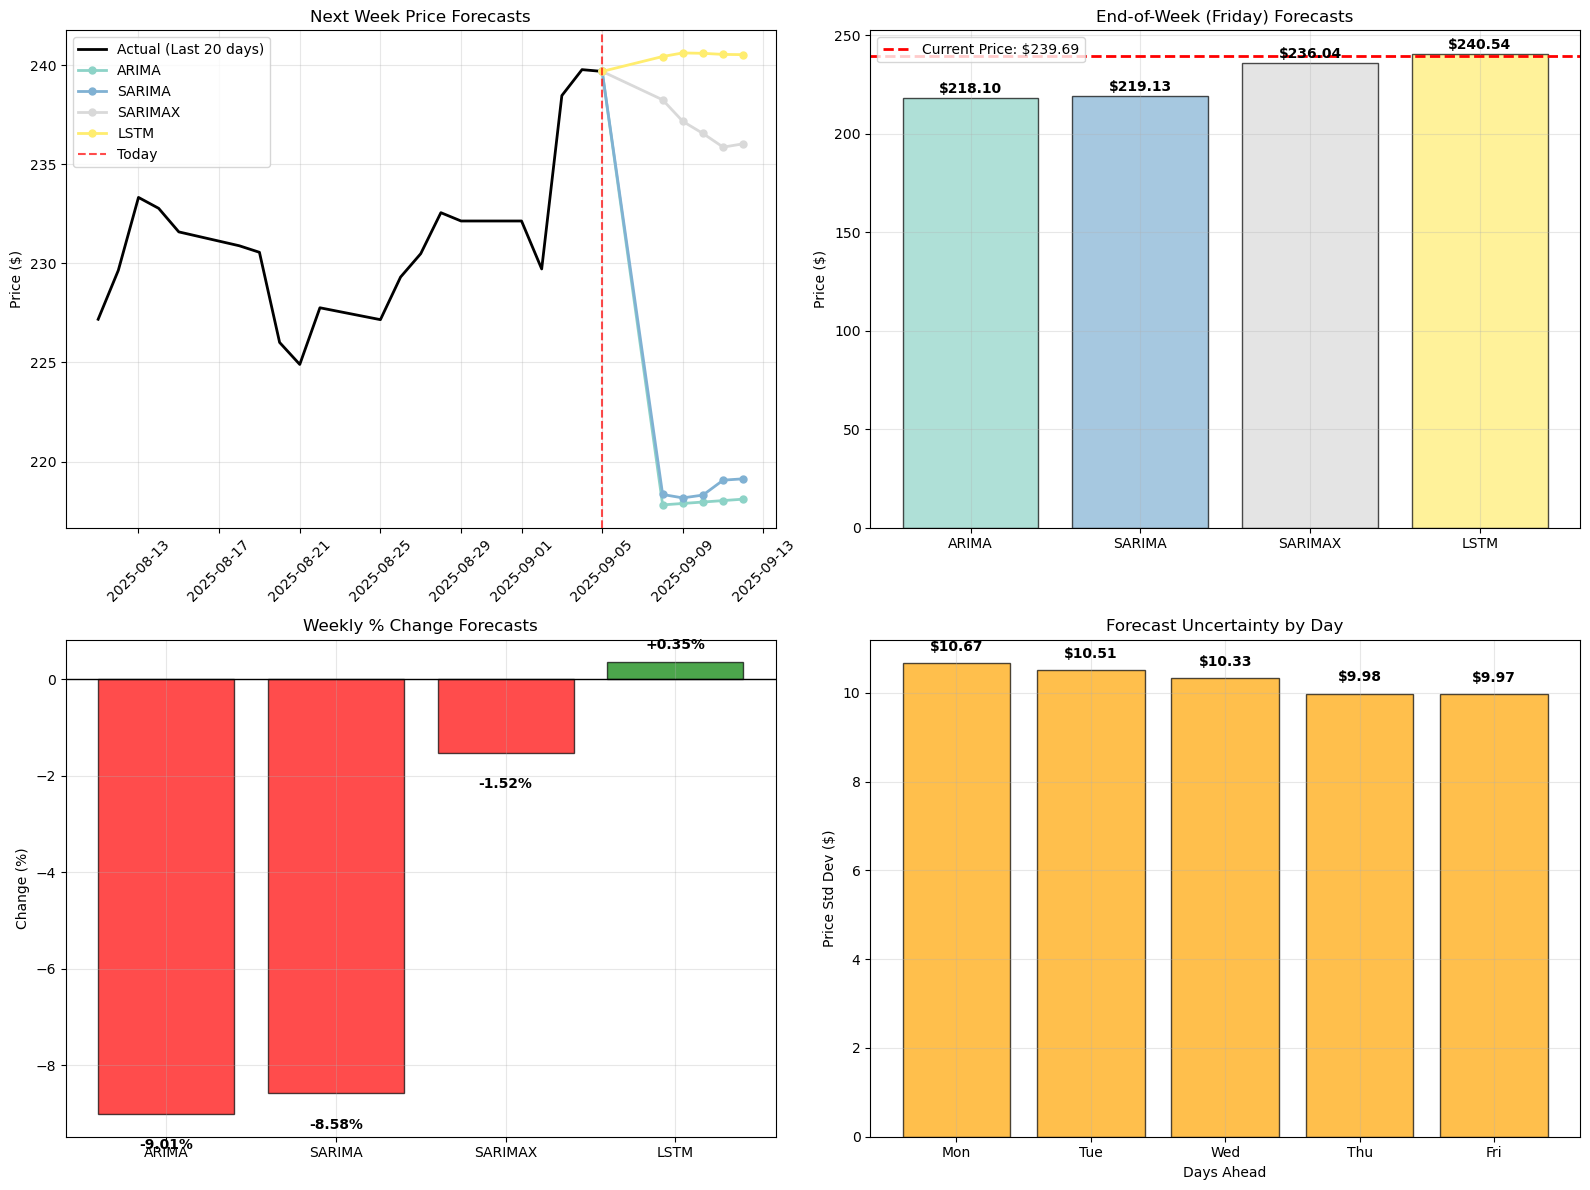


=== Weekly Forecast Summary ===
Current Price: $239.69
Average End-of-Week Forecast: $228.45 (-4.69%)
Forecast Range: $218.10 - $240.54
Forecast Uncertainty (Std): $9.97
Models Agreement: Moderate

[INFO] Script completed successfully!


In [19]:
print("\n=== Next Week (5 Business Days) Forecasts ===")
FORECAST_DAYS = 5  # Next business week
last_exog = exog.iloc[[-1]]

# Store forecasts for plotting
weekly_forecasts = {}
current_price = float(target.iloc[-1])

# Generate future exogenous variables (repeat last known values)
future_exog = pd.concat([last_exog] * FORECAST_DAYS, ignore_index=True)

try:
    if 'arima_model' in locals():
        arima_forecast = arima_model.predict(n_periods=FORECAST_DAYS)
        weekly_forecasts['ARIMA'] = arima_forecast
        print(f"ARIMA  week-end: ${arima_forecast[-1]:.2f}")
except Exception as e:
    print(f"ARIMA  forecast: Failed ({e})")

try:
    if 'sarima_model' in locals():
        sarima_forecast = sarima_model.predict(n_periods=FORECAST_DAYS)
        weekly_forecasts['SARIMA'] = sarima_forecast
        print(f"SARIMA week-end: ${sarima_forecast[-1]:.2f}")
except Exception as e:
    print(f"SARIMA forecast: Failed ({e})")

try:
    if 'sarimax_model' in locals():
        sarimax_forecast = sarimax_model.predict(n_periods=FORECAST_DAYS, X=future_exog)
        weekly_forecasts['SARIMAX'] = sarimax_forecast
        print(f"SARIMAX week-end: ${sarimax_forecast[-1]:.2f}")
except Exception as e:
    print(f"SARIMAX forecast: Failed ({e})")

try:
    if 'model' in locals() and 'scaler' in locals():
        # LSTM weekly forecast: iteratively predict next 5 days
        lstm_weekly = []
        current_window = scaled_all[-WINDOW:].copy()
        
        for day in range(FORECAST_DAYS):
            next_pred_scaled = model.predict(current_window.reshape(1, WINDOW, 1), verbose=0)[0, 0]
            lstm_weekly.append(next_pred_scaled)
            # Update window: remove first element, add prediction
            current_window = np.roll(current_window, -1, axis=0)
            current_window[-1, 0] = next_pred_scaled
        
        # Convert back to original scale
        lstm_weekly_scaled = np.array(lstm_weekly).reshape(-1, 1)
        lstm_weekly_prices = scaler.inverse_transform(lstm_weekly_scaled).ravel()
        weekly_forecasts['LSTM'] = lstm_weekly_prices
        print(f"LSTM   week-end: ${lstm_weekly_prices[-1]:.2f}")
except Exception as e:
    print(f"LSTM   forecast: Failed ({e})")

# Plot weekly forecasts if we have any
if weekly_forecasts:
    # Create future business days index
    last_date = target.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=FORECAST_DAYS)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Weekly forecast trajectories
    colors = plt.cm.Set3(np.linspace(0, 1, len(weekly_forecasts)))
    
    # Show last 20 days of actual data for context
    context_data = target.tail(20)
    ax1.plot(context_data.index, context_data.values, 'k-', linewidth=2, label='Actual (Last 20 days)')
    
    for i, (model_name, forecast) in enumerate(weekly_forecasts.items()):
        # Connect current price to first forecast
        extended_dates = [target.index[-1]] + list(future_dates)
        extended_prices = [current_price] + list(forecast)
        ax1.plot(extended_dates, extended_prices, 'o-', color=colors[i], 
                label=f'{model_name}', linewidth=2, markersize=5)
    
    ax1.axvline(x=target.index[-1], color='red', linestyle='--', alpha=0.7, 
                label='Today')
    ax1.set_title('Next Week Price Forecasts')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: End-of-week predictions
    models = list(weekly_forecasts.keys())
    week_end_prices = [forecast[-1] for forecast in weekly_forecasts.values()]
    
    bars = ax2.bar(models, week_end_prices, color=colors, alpha=0.7, edgecolor='black')
    ax2.axhline(y=current_price, color='red', linestyle='--', linewidth=2, 
                label=f'Current Price: ${current_price:.2f}')
    ax2.set_title('End-of-Week (Friday) Forecasts')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, price in zip(bars, week_end_prices):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'${price:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Weekly percentage changes
    weekly_pct_changes = [(price - current_price) / current_price * 100 
                         for price in week_end_prices]
    colors_pct = ['green' if pct > 0 else 'red' for pct in weekly_pct_changes]
    
    bars3 = ax3.bar(models, weekly_pct_changes, color=colors_pct, alpha=0.7, edgecolor='black')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.set_title('Weekly % Change Forecasts')
    ax3.set_ylabel('Change (%)')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, pct in zip(bars3, weekly_pct_changes):
        y_pos = bar.get_height() + (0.2 if pct >= 0 else -0.5)
        ax3.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{pct:+.2f}%', ha='center', va='bottom' if pct >= 0 else 'top', 
                fontweight='bold')
    
    # Plot 4: Daily volatility (standard deviation of forecasts)
    daily_volatility = []
    for day in range(FORECAST_DAYS):
        day_prices = [forecast[day] for forecast in weekly_forecasts.values()]
        daily_volatility.append(np.std(day_prices))
    
    ax4.bar(range(1, FORECAST_DAYS+1), daily_volatility, alpha=0.7, 
            color='orange', edgecolor='black')
    ax4.set_title('Forecast Uncertainty by Day')
    ax4.set_xlabel('Days Ahead')
    ax4.set_ylabel('Price Std Dev ($)')
    ax4.set_xticks(range(1, FORECAST_DAYS+1))
    ax4.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for i, vol in enumerate(daily_volatility):
        ax4.text(i+1, vol + max(daily_volatility)*0.02, f'${vol:.2f}', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    if len(weekly_forecasts) > 1:
        avg_week_end = np.mean(week_end_prices)
        std_week_end = np.std(week_end_prices)
        avg_change = (avg_week_end - current_price) / current_price * 100
        
        print(f"\n=== Weekly Forecast Summary ===")
        print(f"Current Price: ${current_price:.2f}")
        print(f"Average End-of-Week Forecast: ${avg_week_end:.2f} ({avg_change:+.2f}%)")
        print(f"Forecast Range: ${min(week_end_prices):.2f} - ${max(week_end_prices):.2f}")
        print(f"Forecast Uncertainty (Std): ${std_week_end:.2f}")
        print(f"Models Agreement: {'High' if std_week_end < current_price * 0.02 else 'Moderate' if std_week_end < current_price * 0.05 else 'Low'}")

print("\n[INFO] Script completed successfully!")